### Gaussian Random Field Regression

In this notebook, we are going to use a Fourier space optimisable filter with the scattering transform for the task of image regression. The data will be a set of Gaussian Random Fields (GRFs) that have corresponding power spectra proportional to $k^{-n}$ where $n$ is the target parameter. This is trivial for the power spectrum, so the scattering transform should have no issue. These are also toy rotationally and translationally invariant fields, so they're suitable for scattering transform to operate on. 

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import numpy as np

import matplotlib.pyplot as plt

from scattering_transform.scattering_transform import ScatteringTransform2d, reduce_coefficients
from scattering_transform.filters import Morlet, FourierTrainable, FixedFilterBank

##### Creating the Dataset and DataLoaders

In [2]:
import numpy as np
from fastpm import FastPM

# Define parameters
L = 256.0  # Box size in Mpc/h
Nmesh = 128  # Mesh resolution
N = 3  # Number of simulations
sigma8_vals = np.linspace(0.5, 1.5, N)  # Array of sigma8 values to vary

# Loop over sigma8 values and generate density fields
for i in range(N):
    sigma8 = sigma8_vals[i]
    solver = FastPM(Nmesh=Nmesh, BoxSize=L, sigma8=sigma8)
    solver.linear_power()
    solver.growth_factor()
    solver.scale_factor_of_chi(0.0)
    initial_conditions = solver.linear_field(seed=i)
    final_field = solver.run(initial_conditions, np.array([1.0]))
    print(final_field.shape)
    break


class GeneralDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]
    

# define datasets

# split =  int(0.8 * len(dataset))
# train_dataset = GRFDataset(fields[:split], spectral_indices[:split])
# val_dataset = GRFDataset(fields[split:], spectral_indices[split:])

# # define dataloaders for train and validation sets
# train_loader = DataLoader(train_dataset, batch_size=32)
# val_loader = DataLoader(val_dataset, batch_size=32)


# # also going to make a pre-processed ST dataset for comparison
# train_loader = DataLoader

C:\Users\s4480225\PycharmProjects\ScatteringTransform\venv\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Let's take a look at some examples:



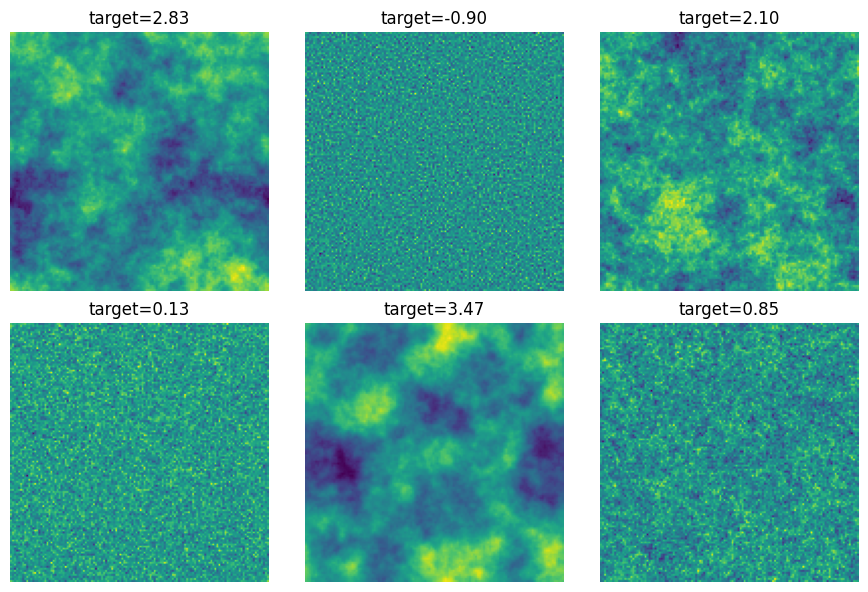

In [4]:
def plot_grid(data, targets, ncols, nrows, plot_fn):
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3))

    for i in range(nrows):
        for j in range(ncols):
            idx = i * ncols + j
            field, n = data[idx], targets[idx]
            plot_fn(axs[i, j], field)
            axs[i, j].set_title("target={:.2f}".format(n.item()))
            axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()


def show_config(ax, field):
    ax.imshow(field)
      
plot_grid(fields, spectral_indices, ncols=3, nrows=2, plot_fn=show_config)

It's also worth considering what these fields look like in Fourier space, given that we will be learning a filter in frequency space and not in configuration space. This also highlights why this is such as easy task -- given that the Morlet scattering transform effectively sums power in a certain frequency band (i.e. an approximate ring in Fourier space), it should be easy to distinguish these fields. 

In [ ]:
def show_logpk(ax, field):
    ax.imshow(torch.fft.fftshift((torch.fft.fft2(field).abs()**2).log()))
    
plot_grid(fields, spectral_indices, ncols=3, nrows=2, plot_fn=show_logpk)

Firstly, we'll try doing a regression with this MLP on the fixed Morlet scattering transform coefficents. We will calculate the outputs of the scattering transform for the fields first. Applying the ST to a large batch at once will consume too much memory, so instead, we batch apply it:

In [5]:
def batch_apply(data, bs, func, device):
    results = []
    num_batches = data.shape[0] // bs
    num_batches = num_batches if data.shape[0] % bs == 0 else num_batches + 1
    for i in range(num_batches):
        x = data[bs*i:bs*(i+1)]
        x = x.to(device)
        results.append(func(x))
    return torch.cat(results, dim=0)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_scales = 6
num_angles = 6
wavelets = Morlet(size, num_scales, num_angles)
st = ScatteringTransform2d(wavelets)
st.to(device)

data_st = batch_apply(fields, 128, lambda x: reduce_coefficients(*st.scattering_transform(x), reduction='rot_avg'), device)
standard_st = (data_st - data_st.mean(0)) / data_st.std(0)

split =  int(0.8 * len(fields))
train_dataset = GeneralDataset(standard_st[:split], spectral_indices[:split])
val_dataset = GeneralDataset(standard_st[split:], spectral_indices[split:])

# define dataloaders for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=128)
val_loader = DataLoader(val_dataset, batch_size=128)


We'll make a general MLP to go from coefficients to an output n.

In [6]:
class MLP(nn.Module):
    def __init__(self, ins, hiddens, outs):
        super().__init__()
        
        self.seq = nn.Sequential(
            nn.Linear(ins, hiddens),
            nn.LeakyReLU(), 
            nn.Linear(hiddens, hiddens),
            nn.LeakyReLU(),
            nn.Linear(hiddens, outs))
        
    def forward(self, x):
        return self.seq(x)


Now the train and test functions

In [7]:
def train(model, optimizer, criterion, train_loader, device):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward(retain_graph=True)
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader.dataset)


def validate(model, criterion, val_loader, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
    return val_loss / len(val_loader.dataset)


model = MLP(data_st.shape[-1], 32, 1)
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(20):
    train_loss = train(model, optimizer, criterion, train_loader, device)
    val_loss = validate(model, criterion, val_loader, device)

    print(f"Epoch {epoch+1}: train loss = {train_loss:.2e}, val loss = {val_loss:.2e}")



Epoch 1: train loss = 2.94e-02, val loss = 9.88e-03
Epoch 2: train loss = 3.89e-03, val loss = 7.67e-04
Epoch 3: train loss = 2.78e-04, val loss = 9.47e-05
Epoch 4: train loss = 7.78e-05, val loss = 6.42e-05
Epoch 5: train loss = 6.32e-05, val loss = 5.78e-05
Epoch 6: train loss = 5.69e-05, val loss = 5.41e-05
Epoch 7: train loss = 5.23e-05, val loss = 5.04e-05
Epoch 8: train loss = 4.82e-05, val loss = 4.60e-05
Epoch 9: train loss = 4.46e-05, val loss = 4.23e-05
Epoch 10: train loss = 4.16e-05, val loss = 3.92e-05
Epoch 11: train loss = 3.90e-05, val loss = 3.69e-05
Epoch 12: train loss = 3.67e-05, val loss = 3.49e-05
Epoch 13: train loss = 3.47e-05, val loss = 3.32e-05
Epoch 14: train loss = 3.30e-05, val loss = 3.22e-05
Epoch 15: train loss = 3.14e-05, val loss = 3.10e-05
Epoch 16: train loss = 2.99e-05, val loss = 2.98e-05
Epoch 17: train loss = 2.87e-05, val loss = 2.87e-05
Epoch 18: train loss = 2.75e-05, val loss = 2.78e-05
Epoch 19: train loss = 2.65e-05, val loss = 2.70e-05
Ep

To check how well our model is doing, we can plot the predictions against the true values:

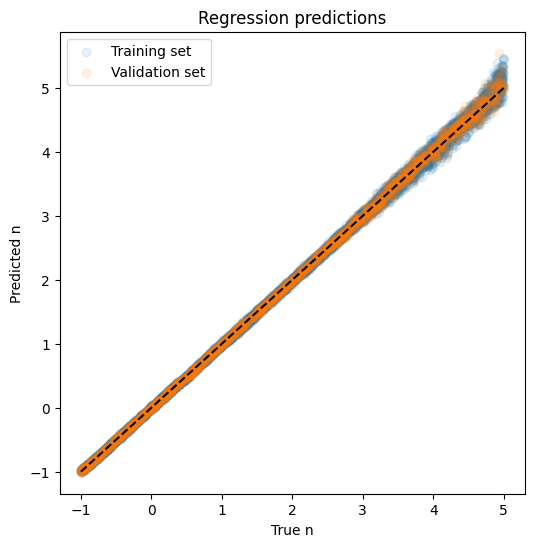

In [8]:
def plot_predictions(model, train_loader, val_loader):
    # Get predictions for the training set
    train_preds = []
    train_targets = []
    for x, y in train_loader:
        with torch.no_grad():
            preds = model(x.to(device))
        train_preds.append(preds.cpu().numpy())
        train_targets.append(y.numpy())
    train_preds = np.concatenate(train_preds, axis=0)
    train_targets = np.concatenate(train_targets, axis=0)

    # Get predictions for the validation set
    val_preds = []
    val_targets = []
    for x, y in val_loader:
        with torch.no_grad():
            preds = model(x.to(device))
        val_preds.append(preds.cpu().numpy())
        val_targets.append(y.numpy())
    val_preds = np.concatenate(val_preds, axis=0)
    val_targets = np.concatenate(val_targets, axis=0)

    # Plot predictions for the training set
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(train_targets, train_preds, alpha=0.1, label='Training set')
    ax.scatter(val_targets, val_preds, alpha=0.1, label='Validation set')
    ax.plot([train_targets.min(), train_targets.max()], [train_targets.min(), train_targets.max()], 'k--')
    ax.set_xlabel('True n')
    ax.set_ylabel('Predicted n')
    ax.set_title('Regression predictions')
    ax.legend()
    plt.show()
    
plot_predictions(model, train_loader, val_loader)

Unsurpisingly, it's a really good prediction! This should be a very easy task for the scattering transform. Next, let's apply the optimisable filters scattering transform to this task:

### Optimisable Filters

We'll need to get the fields into dataloaders:


In [9]:
split =  int(0.8 * len(fields))
train_dataset = GeneralDataset(fields[:split], spectral_indices[:split])
val_dataset = GeneralDataset(fields[split:], spectral_indices[split:])

# define dataloaders for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)


#### Optimising the Filters

We'll first need to combine the MLP regressor with the trainable filters so they can learn in tandem -- an Optimisable Scattering Transform and Regressor (OSTAR).

In [10]:
class OSTAR(nn.Module):
    def __init__(self):
        super().__init__()
        self.wv = FourierTrainable(128, 6, 6)
        self.st = ScatteringTransform2d(self.wv)
        self.st.to(device)
        self.bn = nn.BatchNorm1d(22)
        self.mlp = MLP(22, 32, 1)

    def forward(self, x):
        self.wv.update_filters()
        self.st.clip_filters()
        x = reduce_coefficients(*self.st.scattering_transform(x), reduction='rot_avg')
        return self.mlp(x)

##### Train and Validate the Model

In [11]:
model = OSTAR()
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(20):
    train_loss = train(model, optimizer, criterion, train_loader, device)
    val_loss = validate(model, criterion, val_loader, device)

    print(f"Epoch {epoch+1}: train loss = {train_loss:.2e}, val loss = {val_loss:.2e}")



C:\Users\s4480225\PycharmProjects\ScatteringTransform\venv\lib\site-packages\torch\nn\functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Epoch 1: train loss = 9.45e-02, val loss = 5.06e-02
Epoch 2: train loss = 4.39e-02, val loss = 3.85e-02
Epoch 3: train loss = 3.07e-02, val loss = 2.40e-02
Epoch 4: train loss = 1.75e-02, val loss = 1.28e-02
Epoch 5: train loss = 9.68e-03, val loss = 7.41e-03
Epoch 6: train loss = 5.92e-03, val loss = 4.68e-03
Epoch 7: train loss = 3.75e-03, val loss = 3.07e-03
Epoch 8: train loss = 2.36e-03, val loss = 1.98e-03
Epoch 9: train loss = 1.64e-03, val loss = 1.41e-03
Epoch 10: train loss = 1.19e-03, val loss = 1.03e-03
Epoch 11: train loss = 8.91e-04, val loss = 7.81e-04
Epoch 12: train loss = 7.00e-04, val loss = 6.26e-04
Epoch 13: train loss = 5.75e-04, val loss = 5.08e-04
Epoch 14: train loss = 4.90e-04, val loss = 4.44e-04
Epoch 15: train loss = 4.38e-04, val loss = 4.04e-04
Epoch 16: train loss = 4.02e-04, val loss = 3.79e-04
Epoch 17: train loss = 3.73e-04, val loss = 3.59e-04
Epoch 18: train loss = 3.50e-04, val loss = 3.42e-04
Epoch 19: train loss = 3.31e-04, val loss = 3.27e-04
Ep

How did it go?

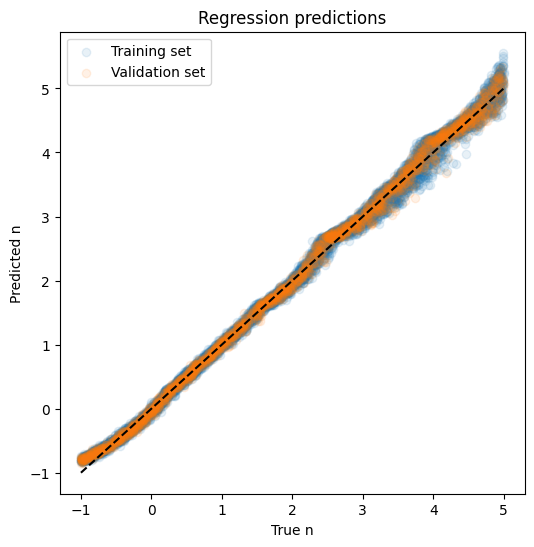

In [12]:
plot_predictions(model, train_loader, val_loader)

After this short amount of training, the filters aren't perfect -- remember, our Morlet filters were chosen for a reason! That being said, with more careful and longer training, it wouldn't be surprising to see them outperform the Morlet filters.

Let's have a look at the filters in Fourier and configuration space:

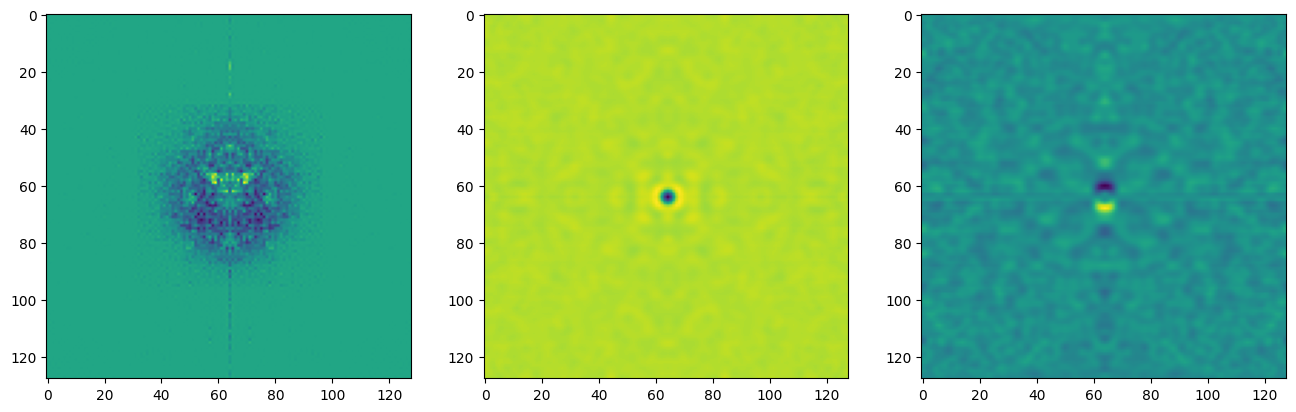

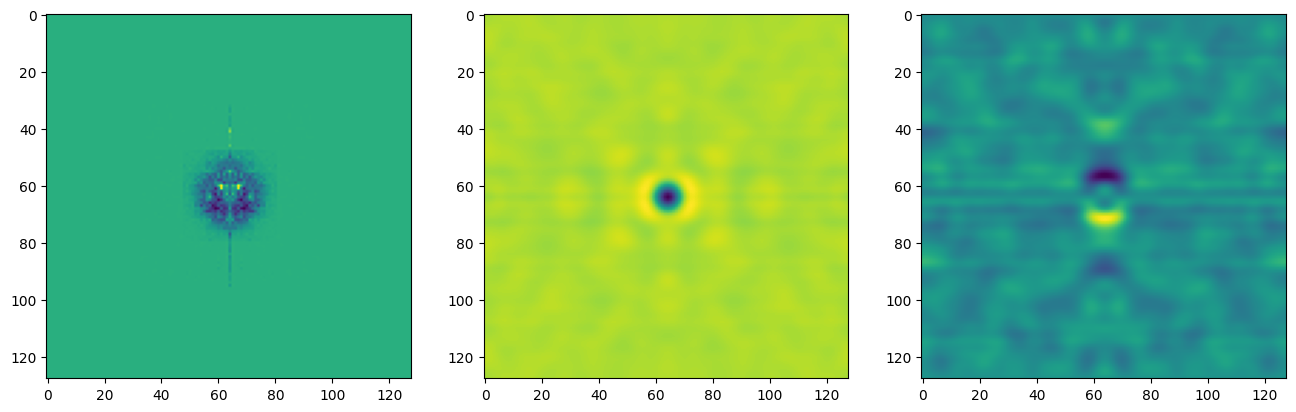

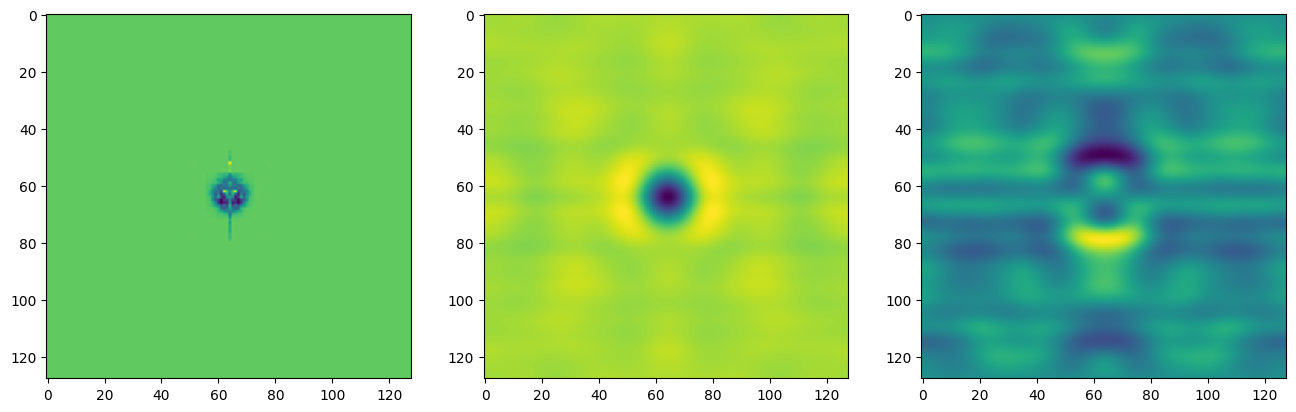

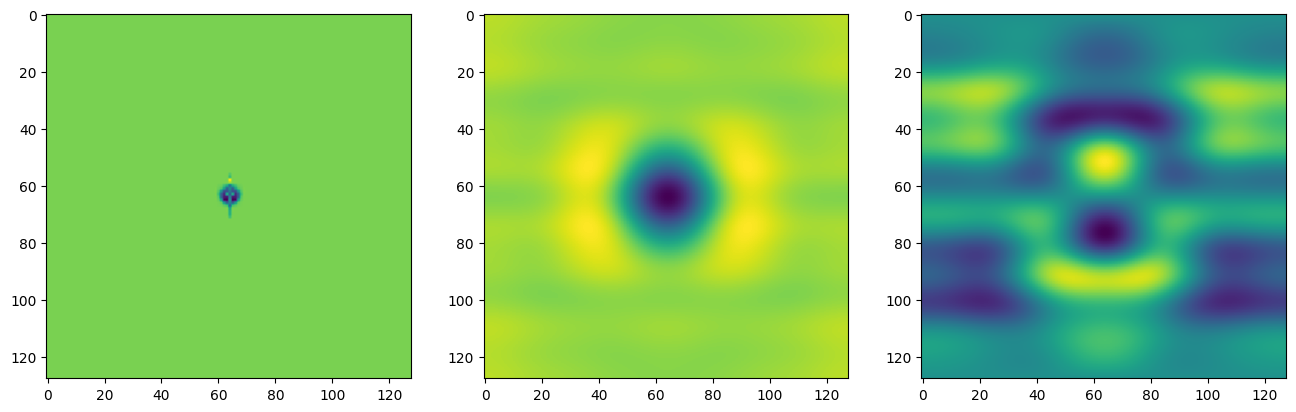

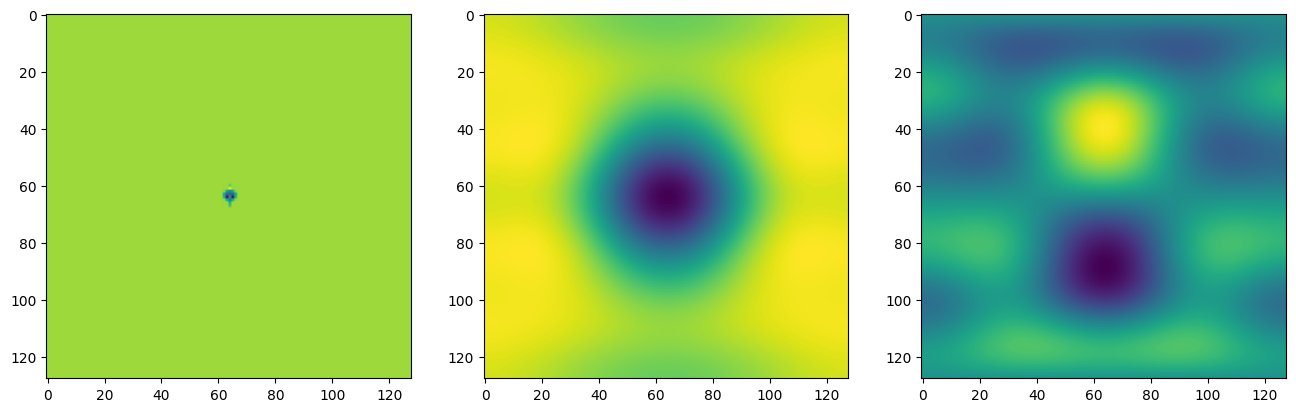

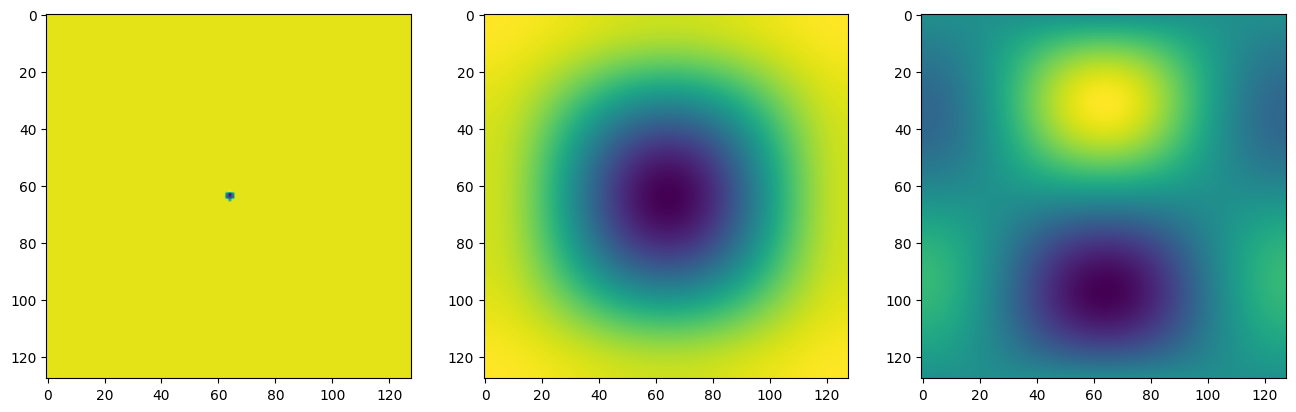

In [25]:
ft = model.wv.filter_tensor.cpu().detach()

for i in range(6):
    fig, axes = plt.subplots(ncols=3, figsize=(16, 6))
    k = ft[i, 0]
    x = torch.fft.fftshift(torch.fft.fft2(k))
    axes[0].imshow(torch.fft.fftshift(k))
    axes[1].imshow(x.real)
    axes[2].imshow(x.imag)
    plt.show()




Even in this short training stint, we've discovered something quite alike the Morlet wavelets! Now let's use these new wavelets in place of the Morlet wavelets to train a standard st:

In [16]:
learnedfilters = model.st.filters.filter_tensor
wavelets = FixedFilterBank(learnedfilters)
st_learned = ScatteringTransform2d(wavelets)
st_learned.to(device)

data_st = batch_apply(fields, 128, lambda x: reduce_coefficients(*st_learned.scattering_transform(x), reduction='rot_avg'), device)
standard_st = (data_st - data_st.mean(0)) / data_st.std(0)

split =  int(0.8 * len(fields))
train_dataset = GeneralDataset(standard_st[:split], spectral_indices[:split])
val_dataset = GeneralDataset(standard_st[split:], spectral_indices[split:])

# define dataloaders for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=128)
val_loader = DataLoader(val_dataset, batch_size=128)


In [20]:
model_learned = MLP(data_st.shape[-1], 32, 1)
model_learned.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_learned.parameters(), lr=1e-3)

for epoch in range(50):
    train_loss = train(model_learned, optimizer, criterion, train_loader, device)
    val_loss = validate(model_learned, criterion, val_loader, device)

    print(f"Epoch {epoch+1}: train loss = {train_loss:.2e}, val loss = {val_loss:.2e}")

Epoch 1: train loss = 3.87e-02, val loss = 2.67e-02
Epoch 2: train loss = 2.35e-02, val loss = 2.08e-02
Epoch 3: train loss = 1.61e-02, val loss = 1.13e-02
Epoch 4: train loss = 6.23e-03, val loss = 3.03e-03
Epoch 5: train loss = 2.39e-03, val loss = 2.08e-03
Epoch 6: train loss = 1.92e-03, val loss = 1.73e-03
Epoch 7: train loss = 1.62e-03, val loss = 1.48e-03
Epoch 8: train loss = 1.38e-03, val loss = 1.26e-03
Epoch 9: train loss = 1.18e-03, val loss = 1.08e-03
Epoch 10: train loss = 1.00e-03, val loss = 9.23e-04
Epoch 11: train loss = 8.58e-04, val loss = 7.90e-04
Epoch 12: train loss = 7.39e-04, val loss = 6.79e-04
Epoch 13: train loss = 6.41e-04, val loss = 5.88e-04
Epoch 14: train loss = 5.60e-04, val loss = 5.10e-04
Epoch 15: train loss = 4.93e-04, val loss = 4.46e-04
Epoch 16: train loss = 4.36e-04, val loss = 3.93e-04
Epoch 17: train loss = 3.89e-04, val loss = 3.53e-04
Epoch 18: train loss = 3.49e-04, val loss = 3.22e-04
Epoch 19: train loss = 3.13e-04, val loss = 2.98e-04
Ep

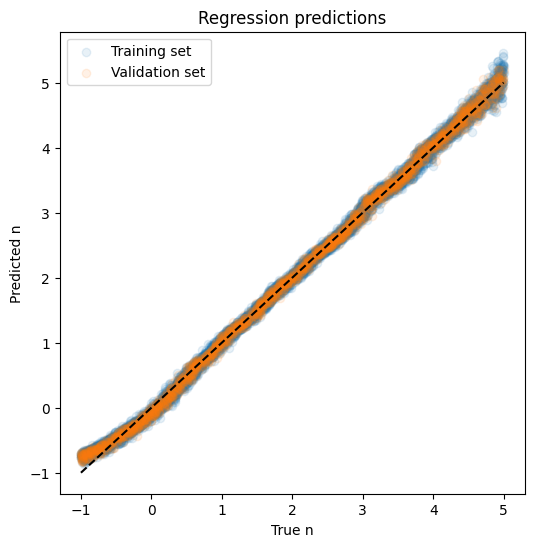

In [23]:
plot_predictions(model_learned, train_loader, val_loader)